# 'House Prices - Advanced Regression Techniques' Kaggle Competition

Submission notebook used to obtain a final RMSE of 0.13124.

Credits to Dominik Gawlik for exploration ideas, in particular the comprehensive way of splitting and keeping track of quantitative vs. qualitative features by storing in separate lists.

In [ ]:
#import relevant libraries
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import Ridge

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from yellowbrick.regressor import ResidualsPlot
from sklearn.preprocessing import StandardScaler

### 1). Data cleaning and exploration

In [2]:
#read dataset
data_train = pd.read_csv("./Data/train.csv")
data_test = pd.read_csv("./Data/test.csv")
data_train.set_index('Id', inplace=True)
data_test.set_index('Id', inplace=True)

In [3]:
data_train['IsTrain'] = 1
data_test['IsTrain'] = 0
data_test['SalePrice'] = np.NaN
data_all = pd.concat([data_train,data_test], sort=True)
data_all['MSSubClass'] = data_all['MSSubClass'].astype(str)

#split quantitative and qualitative features
quantitative = [f for f in data_all.columns if data_all.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('IsTrain')
qualitative = [f for f in data_all.columns if data_all.dtypes[f] == 'object']

In [4]:
#descriptive statistics summary
data_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

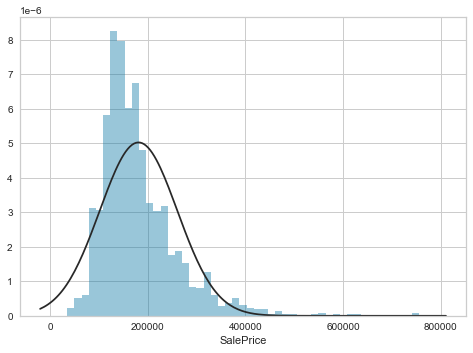

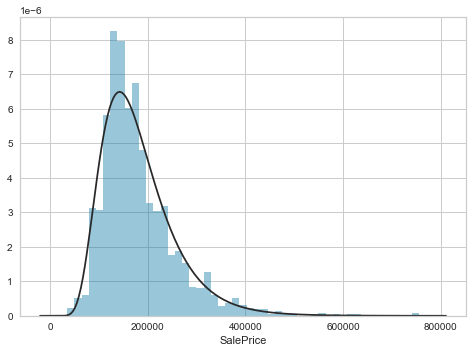

In [5]:
#histograms
plt.figure()
sns.distplot(data_train['SalePrice'], kde=False, fit=stats.norm);
plt.figure()
sns.distplot(data_train['SalePrice'], kde=False, fit=stats.lognorm);

In [7]:
#missing data
total = data_all.isnull().sum().sort_values(ascending=False)
total = total.drop('SalePrice')
percent = (data_all.isnull().sum()/data_all.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Total'] > 0]
missing_data.head(15)

,Total,Percent
PoolQC,2909.0,0.996574
MiscFeature,2814.0,0.964029
Alley,2721.0,0.932169
Fence,2348.0,0.804385
FireplaceQu,1420.0,0.486468
LotFrontage,486.0,0.166495
GarageQual,159.0,0.054471
GarageFinish,159.0,0.054471
GarageCond,159.0,0.054471
GarageYrBlt,159.0,0.054471


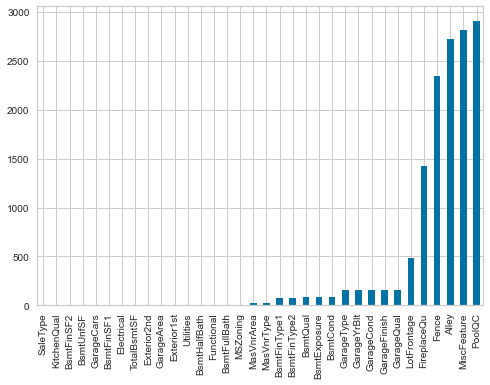

In [8]:
missing_data['Total'].sort_values(ascending=True).plot.bar();

### Quantitative EDA

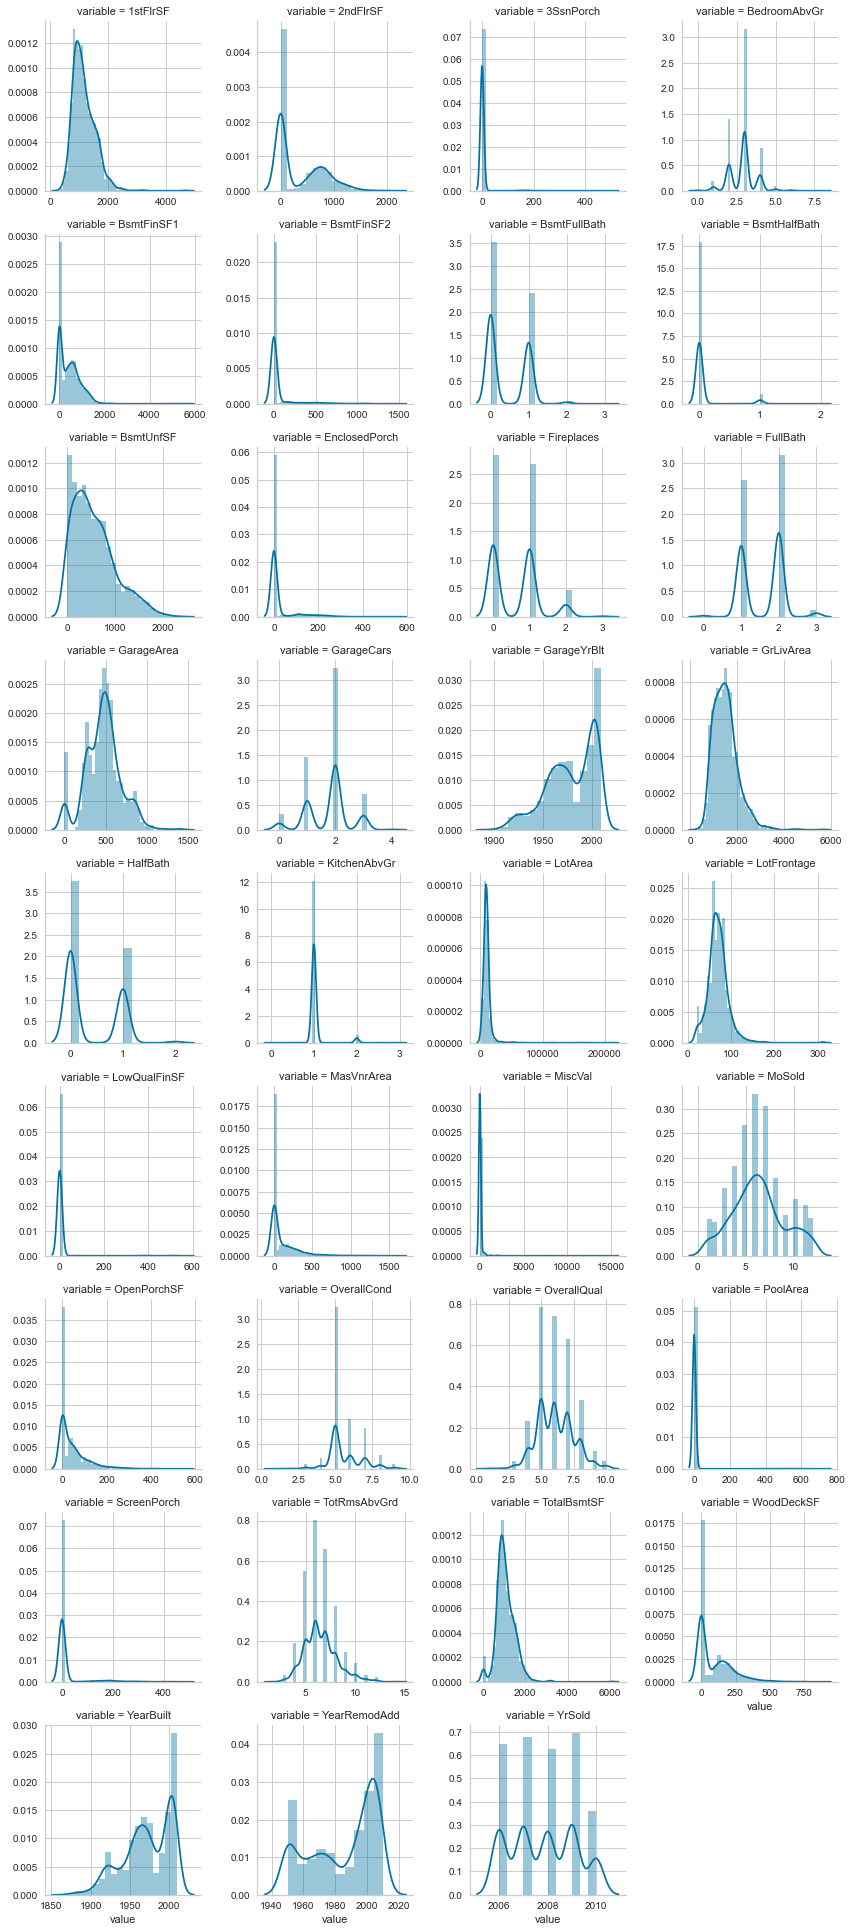

In [9]:
#check for non-normality in quantitative features
pivot = pd.melt(data_all[data_all['IsTrain'] == 1], value_vars=quantitative)
g1 = sns.FacetGrid(pivot, col="variable",  col_wrap=4, sharex=False, sharey=False)
g1 = g1.map(sns.distplot, "value")

Some independent variables look like good candidates for log transformation: TotalBsmtSF, KitchenAbvGr, LotFrontage, LotArea.

In [11]:
#missing values
data_all['Alley'] = data_all['Alley'].fillna('No Alley')
data_all['BsmtCond'] = data_all['BsmtCond'].fillna('No Basement')
data_all['BsmtExposure'] = data_all['BsmtExposure'].fillna('No Basement')
data_all['BsmtFinSF1'] = data_all['BsmtFinSF1'].fillna(data_all[data_all['IsTrain'] == 1]['BsmtFinSF1'].mean())
data_all['BsmtFinSF2'] = data_all['BsmtFinSF2'].fillna(data_all[data_all['IsTrain'] == 1]['BsmtFinSF2'].mean())
data_all['BsmtFinType1'] = data_all['BsmtFinType1'].fillna('No Basement')
data_all['BsmtFinType2'] = data_all['BsmtFinType2'].fillna('No Basement')
data_all['BsmtFullBath'] = data_all['BsmtFullBath'].fillna(data_all[data_all['IsTrain'] == 1]['BsmtFullBath'].median())
data_all['BsmtHalfBath'] = data_all['BsmtHalfBath'].fillna(data_all[data_all['IsTrain'] == 1]['BsmtHalfBath'].median())
data_all['BsmtQual'] = data_all['BsmtQual'].fillna('No Basement')
data_all['BsmtUnfSF'] = data_all['BsmtUnfSF'].fillna(data_all[data_all['IsTrain'] == 1]['BsmtUnfSF'].mean())
#data_all['Electrical'].index[data_all['Electrical'].isnull()]
data_all.drop(labels=1380, axis=0, inplace=True)
data_all['Fence'] = data_all['Fence'].fillna('No Fence')
data_all['FireplaceQu'] = data_all['FireplaceQu'].fillna('No Fireplace')
data_all['GarageArea'] = data_all['GarageArea'].fillna(data_all[data_all['IsTrain'] == 1]['GarageArea'].mean())
data_all['GarageCars'] = data_all['GarageCars'].fillna(data_all[data_all['IsTrain'] == 1]['GarageCars'].median())
data_all['GarageCond'] = data_all['GarageCond'].fillna('No Garage')
data_all['GarageFinish'] = data_all['GarageFinish'].fillna('No Garage')
data_all['GarageQual'] = data_all['GarageQual'].fillna('No Garage')
data_all['GarageType'] = data_all['GarageType'].fillna('No Garage')
GarageYrBlt_median = data_all[data_all['IsTrain'] == 1]['GarageYrBlt'].median(skipna=True)
data_all.loc[list(data_all[data_all['GarageType'] == 'No Garage'].index), 'GarageYrBlt'] = 0.0
data_all['GarageYrBlt'] = data_all['GarageYrBlt'].fillna(GarageYrBlt_median)
#there are 486 LotFrontage na's.
data_all['LotFrontage'] = data_all['LotFrontage'].fillna(0.0)
data_all.loc[list(data_all[data_all['MasVnrArea'].isna()].index), 'MasVnrType'] = 'None'
data_all['MasVnrArea'] = data_all['MasVnrArea'].fillna(0.0)
data_all['MiscFeature'] = data_all['MiscFeature'].fillna('None')
data_all['PoolQC'] = data_all['PoolQC'].fillna('No Pool')
data_all['SaleType'] = data_all['SaleType'].fillna('Oth')
data_all['TotalBsmtSF'] = data_all['TotalBsmtSF'].fillna(0.0)
data_all['Exterior1st'] = data_all['Exterior1st'].fillna(data_all[data_all['IsTrain'] == 1]['Exterior1st'].mode()[0])
data_all['Exterior2nd'] = data_all['Exterior2nd'].fillna(data_all[data_all['IsTrain'] == 1]['Exterior2nd'].mode()[0])
data_all['Functional'] = data_all['Functional'].fillna(data_all[data_all['IsTrain'] == 1]['Functional'].mode()[0])
data_all['KitchenQual'] = data_all['KitchenQual'].fillna(data_all[data_all['IsTrain'] == 1]['KitchenQual'].mode()[0])
data_all['MSZoning'] = data_all['MSZoning'].fillna(data_all[data_all['IsTrain'] == 1]['MSZoning'].mode()[0])
data_all['MasVnrType'] = data_all['MasVnrType'].fillna(data_all[data_all['IsTrain'] == 1]['MasVnrType'].mode()[0])
data_all['Utilities'] = data_all['Utilities'].fillna(data_all[data_all['IsTrain'] == 1]['Utilities'].mode()[0])

### Qualitative EDA

In [12]:
for c in qualitative:
    data_all[c] = data_all[c].astype('category')

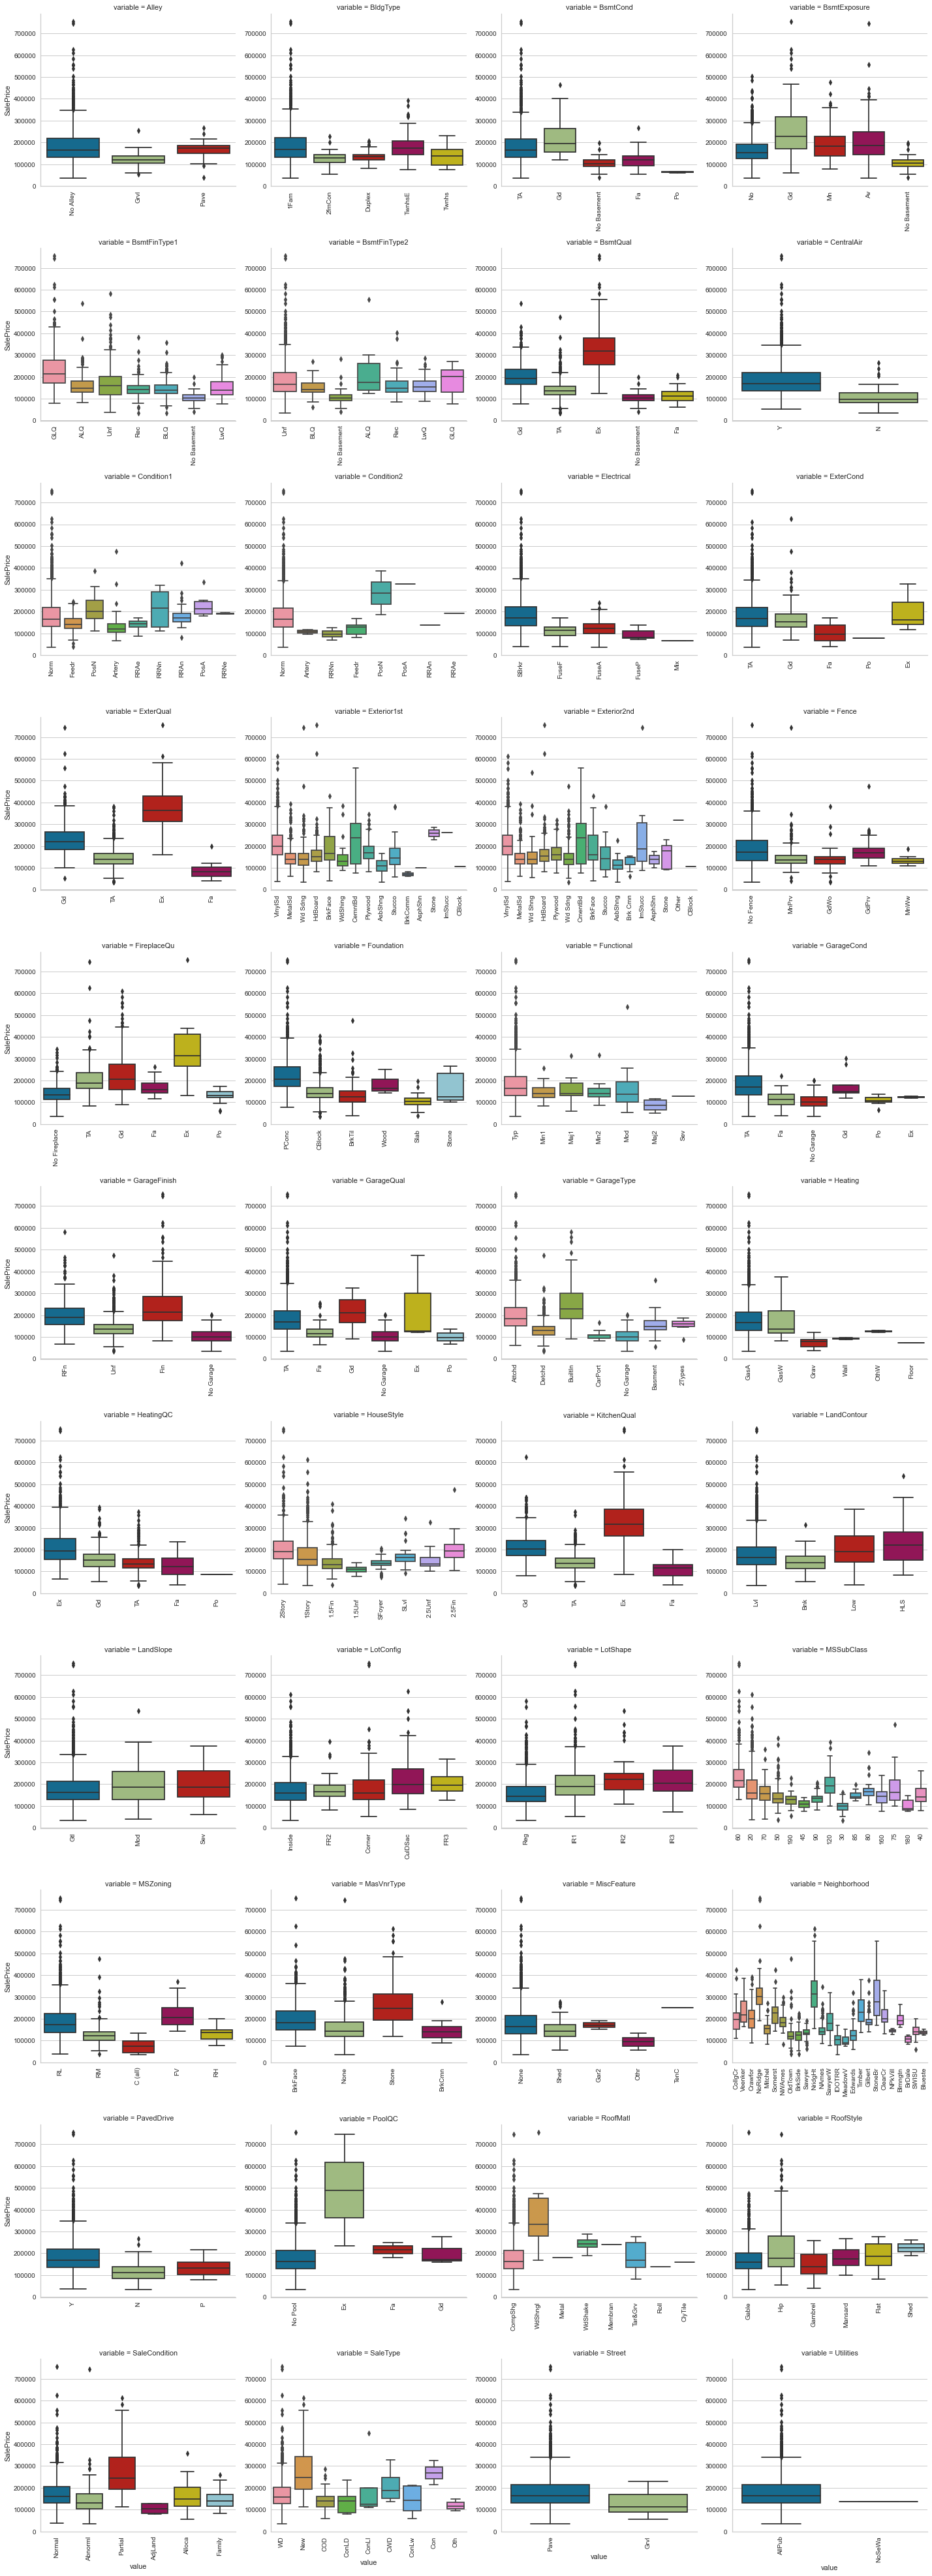

In [13]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
pivot = pd.melt(data_all[data_all['IsTrain'] == 1], id_vars=['SalePrice'], value_vars=qualitative)
g2 = sns.FacetGrid(pivot, col="variable",  col_wrap=4, sharex=False, sharey=False, size=5)
g2 = g2.map(boxplot, "value", "SalePrice")

Some categories seem to more diverse with respect to SalePrice than others. Neighborhood has big impact on house prices. Most expensive seems to be Partial SaleCondition. Having pool on property seems to improve price substantially. There are also differences in variabilities between category values.

We can also do some more quantitative analysis here, e.g. anova.

### 2). Feature engineering

In [16]:
##approach no.1 - label encoding
#data_all[list(data_all.drop(columns=list(data_all.select_dtypes(np.number).columns)).columns)] = data_all[list(data_all.drop(columns=list(data_all.select_dtypes(np.number).columns)).columns)].astype('category')

#cats = data_all.select_dtypes('category').columns
#for i in range(len(cats)):
#    data_all[cats[i]] = data_all[cats[i]].cat.codes

#X_train = data_all[data_all['TrainTest'] == 1].drop(['TrainTest'], axis=1)
#X_test = data_all[data_all['TrainTest'] == 0].drop(['TrainTest'], axis=1)

#y_train = data_all[data_all['TrainTest'] == 1]['SalePrice']

In [17]:
##approach no.2 - OneHotEncoder
#all_dummies = pd.get_dummies(data_all[list(data_all.columns.drop('SalePrice'))])

#X_train = all_dummies[all_dummies['TrainTest'] == 1].drop(['TrainTest'], axis=1)
#X_test = all_dummies[all_dummies['TrainTest'] == 0].drop(['TrainTest'], axis=1)

#y_train = data_all[data_all['TrainTest'] == 1]['SalePrice']

In [18]:
#approach no.3 - custom encoding
def custom_encode(frame, feature):
    ordered = pd.DataFrame()
    ordered['val'] = data_all[feature].unique()
    ordered.index = ordered.val
    ordered['saleprice_mean'] = data_all[data_all['IsTrain'] == 1][[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordered = ordered.sort_values('saleprice_mean')
    ordered['ordering'] = range(1, ordered.shape[0]+1)
    ordered = ordered['ordering'].to_dict()
    
    for cat, order in ordered.items():
        frame.loc[frame[feature] == cat, feature+'_Enc'] = order
    
qual_encoded = []
for q in qualitative:
    custom_encode(data_all, q)
    qual_encoded.append(q+'_Enc')

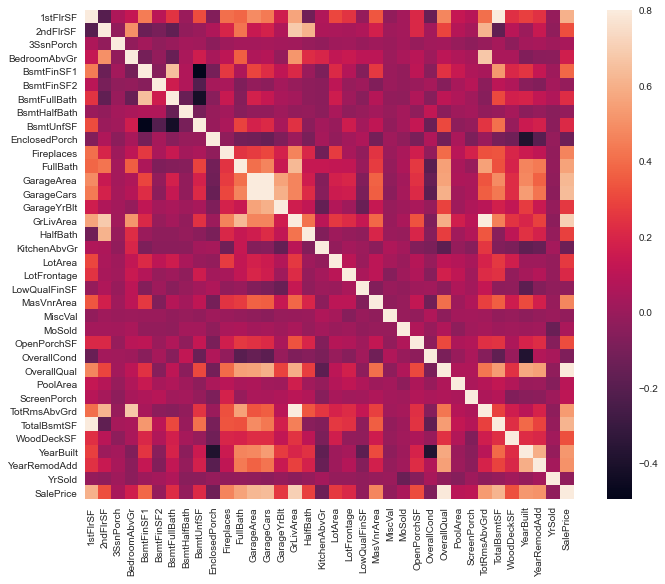

In [19]:
#correlation matrix
corrmat = data_all[data_all['IsTrain'] == 1][quantitative + ['SalePrice']].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.8, square=True);

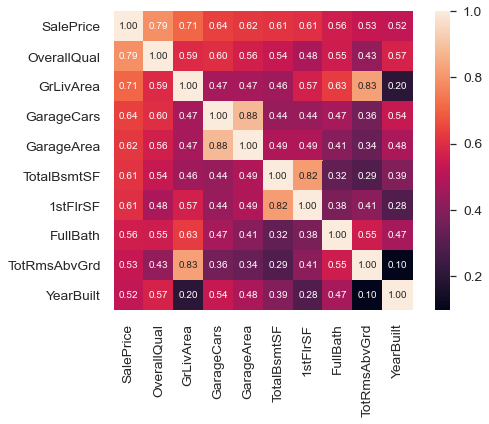

In [20]:
#saleprice correlation matrix - top 10 most correlated features
cols = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
corrmat_sp = data_all[data_all['IsTrain'] == 1][cols].corr()
sns.set(font_scale=1.25)
heat_map = sns.heatmap(corrmat_sp, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Variance Inflation Factor calculated to test for multicollinearity.

TotalBsmtSF and GrLivArea are simply sums of other features, and so we remove them.

There are still several features with high VIF, e.g. GarageYrBlt, YearBuilt - these would be candidates for removal/new feature engineering in further analysis.

In [21]:
features = quantitative + qual_encoded

vif_scaling = data_all[data_all['IsTrain'] == 1][features].copy()
vif_scaling = vif_scaling.drop(columns=['TotalBsmtSF', 'GrLivArea'])


scale = StandardScaler()
vif_scaling[:] = scale.fit_transform(vif_scaling[:])


vif_data = pd.DataFrame()
vif_data["Feature"] = vif_scaling.columns

#calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(vif_scaling.values, i)
                          for i in range(len(vif_scaling.columns))]

In [23]:
vif_data.sort_values(by='VIF', ascending=False).head(15)

,Feature,VIF
14,GarageYrBlt,8.397639
30,YearBuilt,8.162766
0,1stFlrSF,7.908585
52,GarageCond_E,7.882723
4,BsmtFinSF1,7.745364
8,BsmtUnfSF,6.691005
13,GarageCars,6.447445
1,2ndFlrSF,6.153259
54,GarageQual_E,5.793743
47,Exterior2nd_E,5.625682


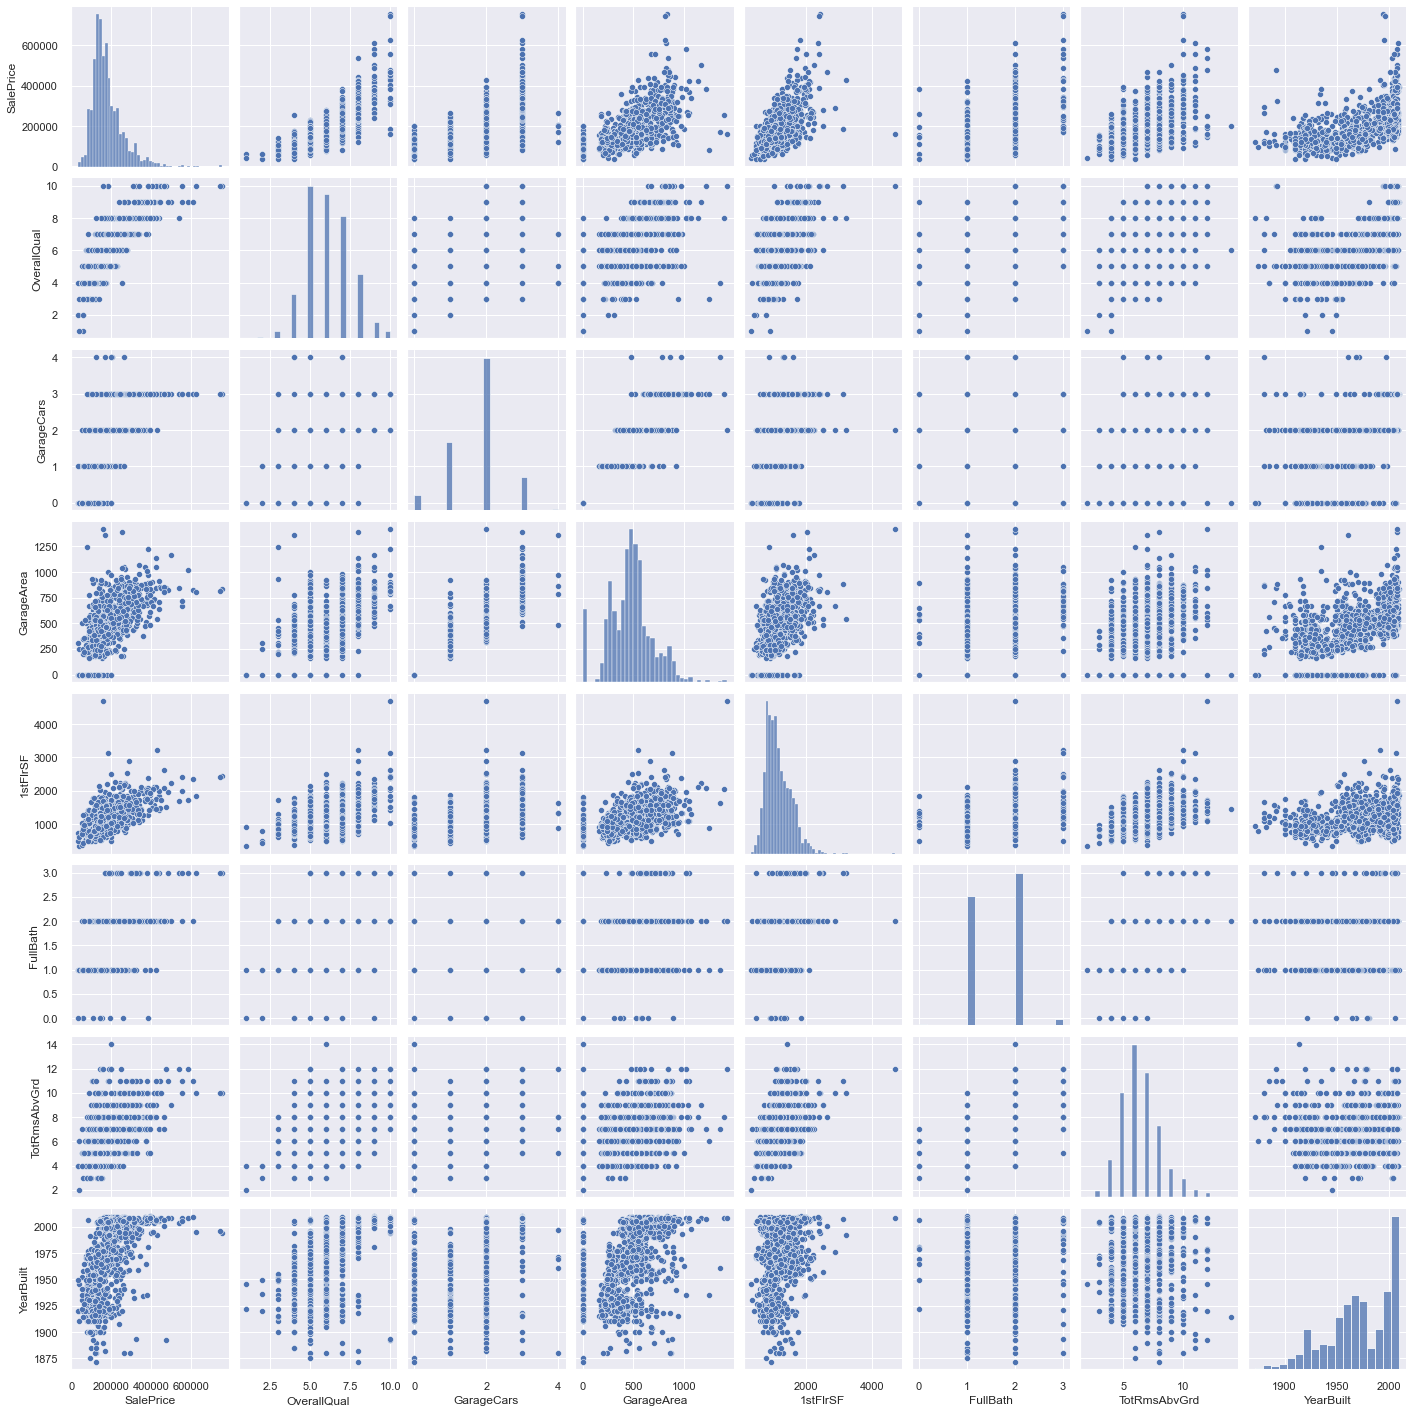

In [24]:
#scatterplot of top 8 correlated variables with sale price.
sns.set()
cols = ['SalePrice', 'OverallQual', 'GarageCars', 'GarageArea', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']
sns.pairplot(data_all[data_all['IsTrain'] == 1][cols], height=2.5)
plt.show();

Some of these plots show features with potential non-linearities. Could apply transformations - to be explored in future analysis.

In [27]:
#feature engineering
data_all['HasBasement'] = data_all['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
data_all = data_all.drop(columns=['TotalBsmtSF'])

data_all['HasGarage'] = data_all['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

data_all['Has2ndFloor'] = data_all['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

data_all['HasMasVnr'] = data_all['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0)

data_all['HasWoodDeck'] = data_all['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)

data_all['HasPorch'] = data_all['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)

data_all['HasPool'] = data_all['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

data_all['HasCondition2'] = data_all.apply(lambda x : 0 if x['Condition1'] == x['Condition2'] else 1, axis=1)

data_all['HasExterior2nd'] = data_all.apply(lambda x : 0 if x['Exterior1st'] == x['Exterior2nd'] else 1, axis=1)

data_all['HasBsmtFinType2'] = data_all.apply(lambda x : 0 if x['BsmtFinType1'] == x['BsmtFinType2'] else 1, axis=1)

data_all['HasRemod'] = data_all.apply(lambda x: 0 if x['YearBuilt'] == x['YearRemodAdd'] else 1, axis=1)

In [28]:
boolean = ['HasBasement', 'HasGarage', 'Has2ndFloor', 'HasMasVnr', 'HasWoodDeck',
            'HasPorch', 'HasPool', 'HasCondition2', 'HasExterior2nd', 'HasBsmtFinType2', 'HasRemod']

### 3). Data preprocessing for modelling

In [29]:
def log_transform(feature):
    data_all[feature] = np.log1p(data_all[feature].values)
    
log_transform('1stFlrSF')
log_transform('2ndFlrSF')
log_transform('LotArea')
log_transform('LotFrontage')
log_transform('KitchenAbvGr')
log_transform('GarageArea')

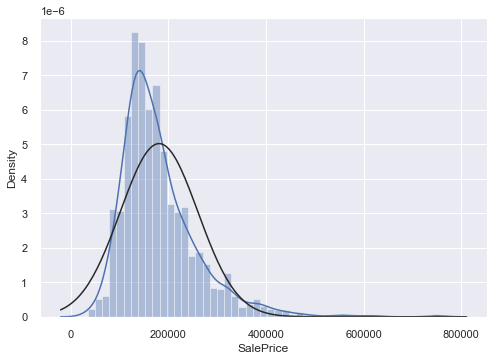

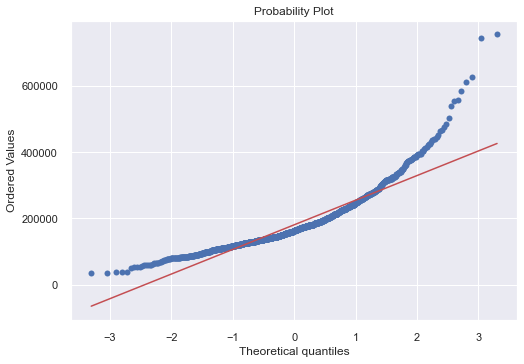

In [30]:
#histogram and normal probability plot
sns.distplot(data_all['SalePrice'].dropna(), fit=stats.norm);
fig = plt.figure()
res = stats.probplot(data_all['SalePrice'].dropna(), plot=plt)

In [31]:
#applying log transformation
data_all['SalePrice'] = np.log(data_all['SalePrice'])

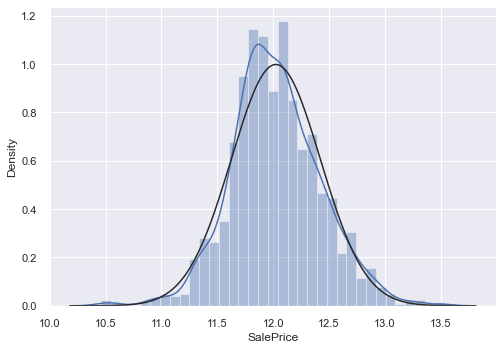

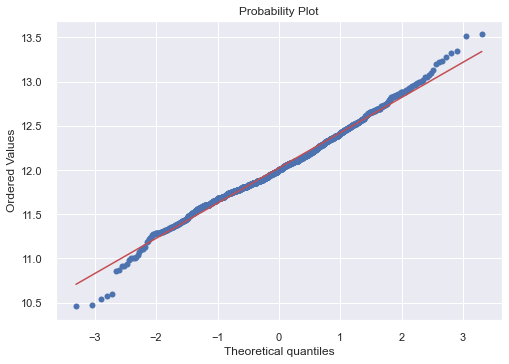

In [32]:
#transformed histogram and normal probability plot
sns.distplot(data_all['SalePrice'].dropna(), fit=stats.norm);
fig = plt.figure()
res = stats.probplot(data_all['SalePrice'].dropna(), plot=plt)

In [33]:
#remove highly-correlated features as per VIF analysis above
quantitative.remove('TotalBsmtSF')
quantitative.remove('GrLivArea')

In [34]:
#final list of features to be included in model training
final_features = quantitative + qual_encoded + boolean

In [35]:
data_all_features = data_all[final_features + ['IsTrain']]
X_train = data_all_features[data_all_features['IsTrain'] == 1]
X_train = X_train.drop(columns=['IsTrain'])
y_train = data_all[data_all['IsTrain'] == 1]['SalePrice']

In [36]:
#Scale data 
scale = StandardScaler()

X_train_scaled = X_train.copy()
X_train_scaled[final_features] = scale.fit_transform(X_train_scaled[final_features])

### 4). Model training and tuning

The Hyperopt library is selected for parameter tuning, which is an approach based on Bayesian Optimization.

#### a). Random Forest Regressor

In [37]:
def hyperopt_train_test_rfr(params):
    rfr = RandomForestRegressor(n_estimators = params['n_estimators'],
                                max_depth = int(params['max_depth']),
                                min_samples_leaf = int(params['min_samples_leaf']),
                                min_samples_split = int(params['min_samples_split']),
                                bootstrap = params['bootstrap'],
                                max_features = params['max_features']
                               )
    return np.mean(np.sqrt(-cross_val_score(rfr, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5)))

rfr_params = {
    'n_estimators': hp.choice('n_estimators', range(100, 525, 25)),
    'max_depth': hp.choice('max_depth', range(5, 55, 5)),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'max_features': hp.choice('max_features', ['auto', 'sqrt'])
}

def f_rfr(params):
    acc = hyperopt_train_test_rfr(params)
    return {'loss': acc, 'status': STATUS_OK}

warnings.filterwarnings(action='ignore', category=DeprecationWarning)
trials = Trials()
best_rfr = fmin(f_rfr, rfr_params, algo=tpe.suggest, max_evals=100, trials=trials, return_argmin=False)
print('best:')
print(best_rfr)

100%|██████████| 100/100 [32:37<00:00, 19.58s/trial, best loss: 0.14238114239041116] 
best:
{'bootstrap': 0, 'max_depth': 5, 'max_features': 0, 'min_samples_leaf': 2.0, 'min_samples_split': 4.0, 'n_estimators': 14}


#### b). XGBoost

In [101]:
def hyperopt_train_test_XGB(params):
    XGB_regressor = xgb.XGBRegressor(objective ='reg:squarederror',
                                     n_estimators = params['n_estimators'],
                                     max_depth = int(params['max_depth']),
                                     learning_rate = params['learning_rate'],
                                     gamma = params['gamma'],
                                     min_child_weight = params['min_child_weight'],
                                     subsample = params['subsample'],
                                     colsample_bytree = params['colsample_bytree']
                            )
    return np.mean(np.sqrt(-cross_val_score(XGB_regressor, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5)))

XGB_params = {
    'n_estimators': hp.choice('n_estimators', range(20, 205, 5)),
    'max_depth': hp.choice('max_depth', range(5, 30, 1)),
    'learning_rate': hp.quniform('learning_rate', 0.01, 0.5, 0.01),
    'gamma': hp.quniform('gamma', 0, 0.50, 0.01),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.quniform('subsample', 0.1, 1, 0.01),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1.0, 0.01)
}

def f_XGB(params):
    acc = hyperopt_train_test_XGB(params)
    return {'loss': acc, 'status': STATUS_OK}

warnings.filterwarnings(action='ignore', category=DeprecationWarning)
trials = Trials()
best_XGB = fmin(f_XGB, XGB_params, algo=tpe.suggest, max_evals=100, trials=trials, return_argmin=False)
print('best:')
print(best_XGB)

100%|██████████| 100/100 [04:08<00:00,  2.49s/trial, best loss: 0.12728831028160362]
best:
{'colsample_bytree': 0.34, 'gamma': 0.04, 'learning_rate': 0.06, 'max_depth': 17, 'min_child_weight': 5.0, 'n_estimators': 150, 'subsample': 0.56}


#### c). Ridge Regression

In [39]:
def hyperopt_train_test_ridge(params):
    ridge = Ridge(alpha = params['alpha']
                            )
    return np.mean(np.sqrt(-cross_val_score(ridge, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5)))

ridge_params = {
    'alpha': hp.quniform('alpha', 0, 1.0, 0.01),
}

def f_ridge(params):
    acc = hyperopt_train_test_ridge(params)
    return {'loss': acc, 'status': STATUS_OK}

warnings.filterwarnings(action='ignore', category=DeprecationWarning)
trials = Trials()
best_ridge = fmin(f_ridge, ridge_params, algo=tpe.suggest, max_evals=100, trials=trials, return_argmin=False)
print('best:')
print(best_ridge)

100%|██████████| 100/100 [00:03<00:00, 29.02trial/s, best loss: 0.13213092001522836]
best:
{'alpha': 0.97}


XGB gives the best RMSE of the models tried. We now check feature importance:

In [143]:
XGB_optimised = xgb.XGBRegressor(objective ='reg:squarederror',
                                     n_estimators = best_XGB['n_estimators'],
                                     max_depth = int(best_XGB['max_depth']),
                                     learning_rate = best_XGB['learning_rate'],
                                     gamma = best_XGB['gamma'],
                                     min_child_weight = best_XGB['min_child_weight'],
                                     subsample = best_XGB['subsample'],
                                     colsample_bytree = best_XGB['colsample_bytree']
                            )

In [144]:
XGB_optimised.fit(X_train_scaled, y_train);

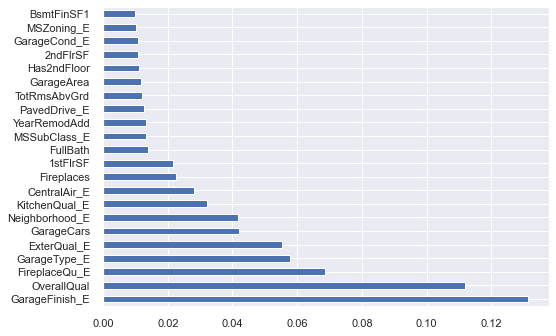

In [133]:
feat_importances = pd.Series(XGB_optimised.feature_importances_, index=X_train_scaled.columns)
feat_importances.sort_values(ascending=False)[feat_importances > 0.01].plot(kind='barh');

In [134]:
##does dropping unimportant features have any effect on the RMSE?
#top_features = list(feat_importances.sort_values(ascending=False)[feat_importances > 0.01].index)

In [137]:
n_scores_optimised = -cross_val_score(XGB_optimised, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5)

#report performance
print('RMSE: %.3f (%.3f)' % (np.mean(np.sqrt(n_scores_optimised)), np.std(np.sqrt(n_scores_optimised))))

RMSE: 0.127 (0.011)


let us plot the residuals to check for heteroscedasticity:

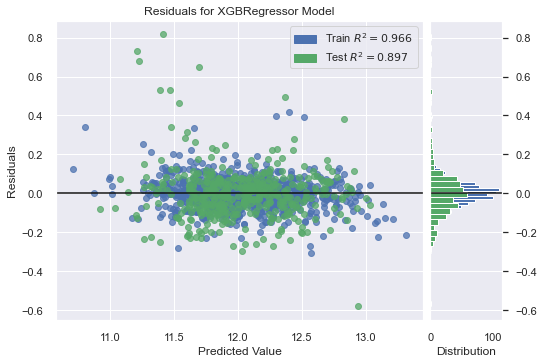

In [140]:
#create train and val data
X_train2, X_val, y_train2, y_val = train_test_split(X_train_scaled, y_train, test_size=0.3, random_state=42)

#instantiate the linear model and visualiser using the best XGB parameters found above
XGB_optimised = xgb.XGBRegressor(objective ='reg:squarederror',
                                     n_estimators = best_XGB['n_estimators'],
                                     max_depth = int(best_XGB['max_depth']),
                                     learning_rate = best_XGB['learning_rate'],
                                     gamma = best_XGB['gamma'],
                                     min_child_weight = best_XGB['min_child_weight'],
                                     subsample = best_XGB['subsample'],
                                     colsample_bytree = best_XGB['colsample_bytree']
                            )
XGB_optimised.fit(X_train2, y_train2)

visualizer = ResidualsPlot(XGB_optimised)

visualizer.fit(X_train2, y_train2) #fit the training data to the visualiser
visualizer.score(X_val, y_val) #evaluate the model on the val data
visualizer.show(); #finalise and render the figure

There is no indication that the variance of the residuals increases as the fitted values increase, so we assume no heterscedasticity.

### 5). Results

In [145]:
X_test = data_all_features[data_all_features['IsTrain'] == 0]
X_test = X_test.drop(columns=['IsTrain'])
X_test_scaled = X_test.copy()
X_test_scaled[final_features] = scale.transform(X_test_scaled[final_features])

In [146]:
y_pred = XGB_optimised.predict(X_test_scaled)

In [151]:
y_pred = np.exp(y_pred)

In [153]:
to_upload = pd.DataFrame({'Id': X_test_scaled.index, 'SalePrice': list(y_pred)})
to_upload.to_csv('RB_submission_1.csv', index=False)